<a href="https://colab.research.google.com/github/DSF-Kotaro/blog/blob/main/%E5%9B%B3%E8%A7%A3%E9%80%9F%E7%BF%92DeepLearning_016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function
from sklearn.model_selection import train_test_split

import tensorflow as tf
import matplotlib.pyplot as plt
import unicodedata
import re
import numpy as np
import os
import time

In [2]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://download.tensorflow.org/data/spa-eng.zip', 
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [3]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    return word_pairs

In [5]:
class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      self.vocab.update(phrase.split(' '))
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

In [6]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(path, num_examples):
    pairs = create_dataset(path, num_examples)

    inp_lang = LanguageIndex(sp for en, sp in pairs)
    targ_lang = LanguageIndex(en for en, sp in pairs)
    
    input_tensor = [[inp_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]
    
    target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [7]:
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

In [8]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

In [9]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [14]:
def gru(units):
  if tf.test.is_gpu_available():
    return tf.compat.v1.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.compat.v1.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [15]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        

        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):     
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        attention_weights = tf.nn.softmax(score, axis=1)
        
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        output, state = self.gru(x)
        
        output = tf.reshape(output, (-1, output.shape[2]))
        
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [17]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [19]:
optimizer = tf.compat.v1.train.AdamOptimizer()


def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [21]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            for t in range(1, targ.shape[1]):
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6023
Epoch 1 Batch 100 Loss 2.2196
Epoch 1 Batch 200 Loss 1.8193
Epoch 1 Batch 300 Loss 1.6885
Epoch 1 Loss 2.0454
Time taken for 1 epoch 94.23614954948425 sec

Epoch 2 Batch 0 Loss 1.5558
Epoch 2 Batch 100 Loss 1.5372
Epoch 2 Batch 200 Loss 1.4292
Epoch 2 Batch 300 Loss 1.2719
Epoch 2 Loss 1.4022
Time taken for 1 epoch 80.65041279792786 sec

Epoch 3 Batch 0 Loss 1.0421
Epoch 3 Batch 100 Loss 0.9715
Epoch 3 Batch 200 Loss 0.9801
Epoch 3 Batch 300 Loss 0.9490
Epoch 3 Loss 0.9857
Time taken for 1 epoch 81.91274046897888 sec

Epoch 4 Batch 0 Loss 0.7118
Epoch 4 Batch 100 Loss 0.7758
Epoch 4 Batch 200 Loss 0.7018
Epoch 4 Batch 300 Loss 0.7011
Epoch 4 Loss 0.6691
Time taken for 1 epoch 81.89177441596985 sec

Epoch 5 Batch 0 Loss 0.4490
Epoch 5 Batch 100 Loss 0.4307
Epoch 5 Batch 200 Loss 0.5139
Epoch 5 Batch 300 Loss 0.4714
Epoch 5 Loss 0.4574
Time taken for 1 epoch 81.34421133995056 sec

Epoch 6 Batch 0 Loss 0.3403
Epoch 6 Batch 100 Loss 0.3289
Epoch 6 Batch 200 Loss

In [22]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.compat.v1.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [23]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [24]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


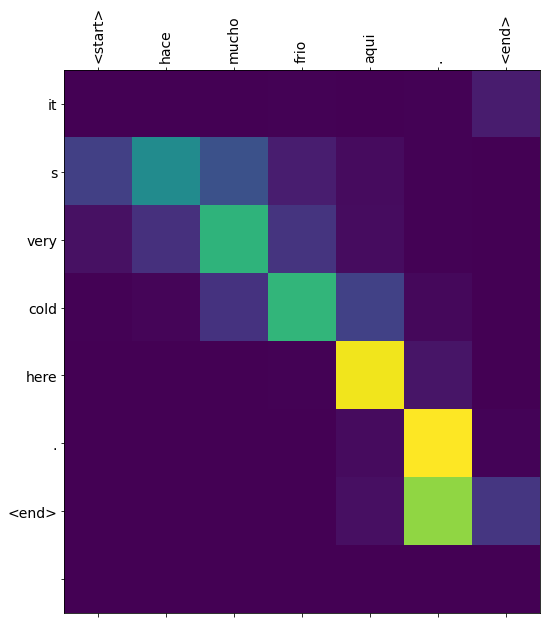

In [26]:
translate(u'hace mucho frio aqui.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


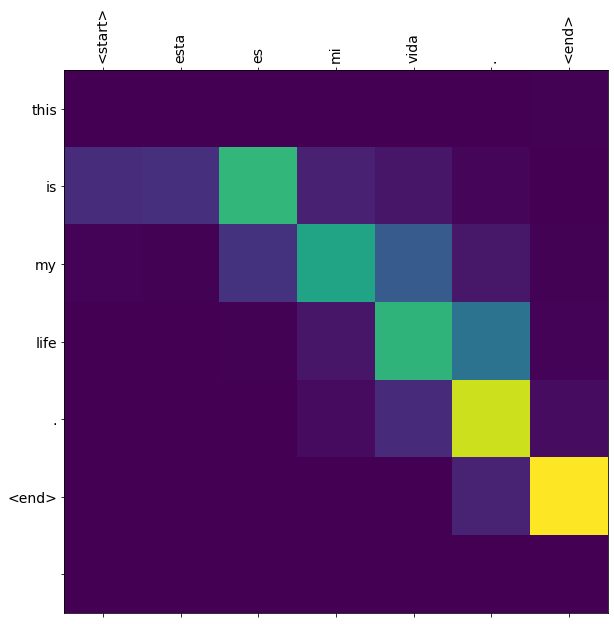

In [27]:
translate(u'esta es mi vida.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> todavia estan en casa ? <end>
Predicted translation: you re still at home . <end> 


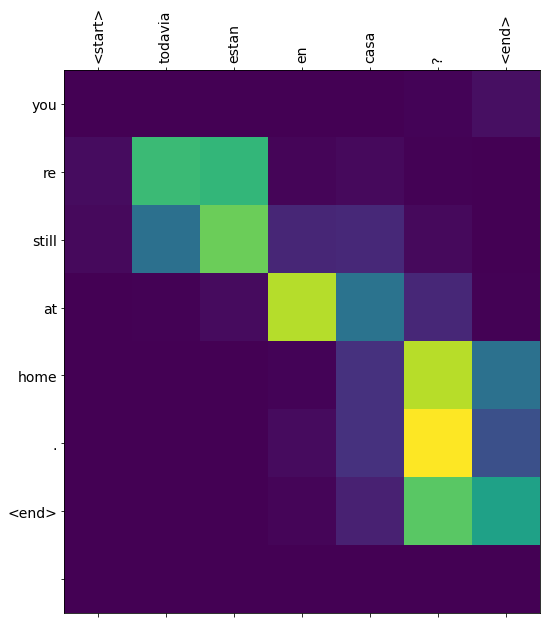

In [28]:
translate(u'todavia estan en casa?', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


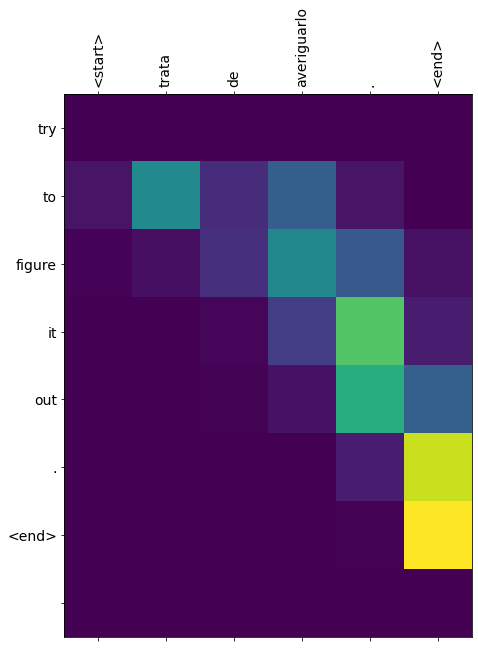

In [29]:
translate(u'trata de averiguarlo.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)